<span style="float: left;padding: 1.3em">![logo](../logo.png)</span>


#  Gravitational Wave Open Data Workshop #7


## Tutorial 3.1: An introduction to parameter estimation

In this tutorial, we will introduce Bayesian inference and "parameter estimation", a crucial part of gravitational wave astronomy. We will start with a general introduction to inference, the idea of stochastic sampling, and then introduce the 
[bilby Bayesian inference library](https://lscsoft.docs.ligo.org/bilby/).
   

[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2024/blob/main/Tutorials/Day_3/Tuto_3.1_Introduction_to_parameter_estimation.ipynb)

## Installation

In [1]:
# -- Use the following line in Google Colab
# ! pip install -q bilby==2.2.2 matplotlib==3.7.3 dynesty==2.1.2 corner==2.2.2

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

### Download sample data

If you are running on Google Colab, or another environment which copies the notebook but not the sample data. Please run the following cell. (Note: you may also download the file directly).

In [2]:
import os
if not os.path.isfile("toy_model.csv"):
  print("Downloading toy_model.csv")
  ! wget https://raw.githubusercontent.com/gw-odw/odw-2024/main/Tutorials/Day_3/toy_model.csv
else:
  print("toy_model.csv exists; not downloading")

toy_model.csv exists; not downloading


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import bilby
import corner

for module in [np, matplotlib, bilby, corner]:
    print(f"Loaded {module.__name__}: {module.__version__}")

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Loaded numpy: 1.24.4
Loaded matplotlib: 3.7.3
Loaded bilby: 2.2.2
Loaded corner: 2.2.2


### Bayesian inference

Let us assume we are given some data $d$ and we wish to use the data to learn about a model $M$ with associated parameters $\theta$. Bayes' theorem provides a framework to do this. Namely, the *posterior* probability distribution of the parameters $\theta$ can be calculated from

$$ p(\theta | d, M) = \frac{\mathcal{L}(d| \theta, M) \;\pi(\theta | M)}{\mathcal{Z}(d | M)} $$

where $\mathcal{L}(d| \theta, M)$ is the *likelihood*, $\pi(\theta | M)$ is the *prior* probability distribution, and $\mathcal{Z}(d | M)$ is the *evidence* (or fully marginalized likelihood) which normalized the posterior, i.e.

$$ \mathcal{Z}(d | M) = \int \mathcal{L}(d| \theta, M) \;\pi(\theta | M)\, d\theta $$

For most interesting problems, the posterior and evidence (i.e. $p(\theta | d, M) $ and $\mathcal{Z}(d | M) $) cannot be calculated in closed form. Instead we rely on computational methods to approximate them - in this tutorials we will use **stochastic sampling**.

Approximating $p(\theta | d, M)$ is known as **parameter estimation** for obvious reasons. However, let us briefly note that Bayesian inference also extends to **model comparison** as follows. If we have two models, say $M_A$ and $M_B$, then Bayes theorem also tells us that

$$ \frac{P(M_A | d)}{P(M_B | d)} = \frac{\mathcal{Z}(d | M_A)}{\mathcal{Z}(d | M_B)} \frac{\pi(M_A)}{\pi(M_B)} $$

This ratio known as the *posterior odds* compares the relative probability of each model. If it is greater than 1 this implies evidence for $M_A$ whereas if it is less than 1 it implies evidence for $M_B$. The right hand side is the product of the *Bayes factor* $\frac{\mathcal{Z}(d | M_A)}{\mathcal{Z}(d | M_B)}$ (which can be estimated using stochastic sampling) and the *prior odds* $\frac{\pi(M_A)}{\pi(M_B)}$.

### Introducing a toy model

In order to introduce the basics of Bayesian inference and stochastic sampling, let us introduce some example data and then a toy model with parameters for us to estimate. In this repository, we include our data `toy_model.csv`. This is a text file containing an observed timeseries of `yobs` recorded at times `time`. We now read in the data and plot it

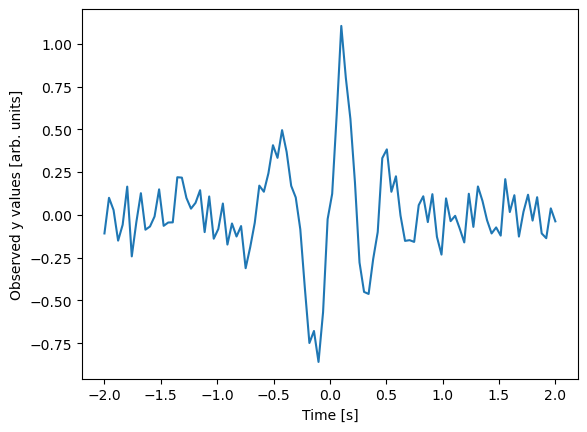

In [4]:
time, yobs = np.genfromtxt("toy_model.csv", delimiter=",").T
fig, ax = plt.subplots()
ax.plot(time, yobs)
ax.set(xlabel="Time [s]", ylabel="Observed y values [arb. units]")
plt.show()

We are told by our tame theoretician, that a good model to explain this data is a so-called *sine Gaussian* which consists of a sinusoidal function modulated with a Gaussian-exponential envelope, i.e.

$$ M_s: s(t) = e^{-(t/\alpha)^2} \sin\left(2\pi f t\right)  $$

where $M_s$ will be our label for the sine-Gaussian model. This model has two parameters $f$ and $\alpha$; we could further generalise this to have an arbitrary amplitude, phase shift, or time shift, as well but here we introduce the simple two-parameter model for illustration.

Before we go any further, let's check that we understand the model by plotting it out with some arbitrary choices for $f$ and $\alpha$. To do this, we will create some functions that we can use later on. We plot the full function and the individual components to help visualise it.

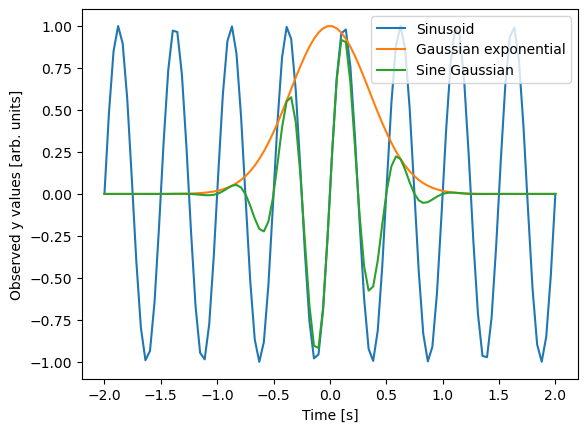

In [5]:
def sinusoid(time, freq):
    return np.sin(2 * np.pi * freq * time)


def gaussian_exponential(time, alpha):
    return np.exp(-(time/alpha)**2)


def model_Ms(time, freq, alpha):
    return gaussian_exponential(time, alpha) * sinusoid(time, freq)

freq = 2
alpha = 0.5

fig, ax = plt.subplots()

ax.plot(time, sinusoid(time, freq), label="Sinusoid")
ax.plot(time, gaussian_exponential(time, alpha), label="Gaussian exponential")
ax.plot(time, model_Ms(time, freq, alpha), label="Sine Gaussian")
ax.set(xlabel="Time [s]", ylabel="Observed y values [arb. units]")
ax.legend()
plt.show()

### Parameter Estimation

Now that we have our data (`yobs`) and our model $M_s$, our task is to estimate the parameters $f$ and $\alpha$. To do this, we will use Bayes theorem, i.e. we want to approximate the distribution

$$ p(\theta | d, M_s) = \frac{\mathcal{L}(d| \theta, M_s) \;\pi(\theta | M_s)}{\mathcal{Z}(d | M_s)} $$

where $\theta={f, \alpha}$ is the two-dimensional parameter vector and $d$ is `yobs` (measured at times `time`). To this end, we need to define the likelihood and priors. Note that, if we are **only interested in the shape of the distribution**, then we can ignore the evidence, i.e. we can estimate the unnormalized distribution

$$ p(\theta | d, M_s) \propto \mathcal{L}(d| \theta, M_s) \;\pi(\theta | M_s) $$

Before proceeding, we need to define our likelihood and prior. 

#### Parameter Estimation: Likelihood

For this toy example, we will assume that the data consists of the generate model $M_s$ and additive white Gaussian noise, i.e.

$$ y_{\rm obs}(t) = s(t; f, \alpha) + \epsilon $$

where $\epsilon \sim N(0, \sigma)$ by which we mean that $\epsilon$ is drawn from a Gaussian distribution with zero mean and standard deviation $\sigma=0.1$ (for now, we will assume this is known a priori, but see challenges below for how it could be estimated). 

This definition of how the data was created allows us to define our likelihood. Namely, given a value of $f, \alpha$, the likelihood of a single data point $y_i$ (measured at $t_i$) is:

$$ \mathcal{L}(y_i| f, \alpha, M_s) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(y_i - s(t_i; f, \alpha))^2}{2\sigma^2}\right) $$

To extend this to multiple data points, we assume they are independent then

$$ \mathcal{L}(y_{obs} | f, \alpha, M_s) = \prod_i \mathcal{L}(y_i| f, \alpha, M_s) $$

In practice, it is wise to work with the logarithm of the likelihood to avoid numerical overflow. Then, we have that

$$ \log \mathcal{L}(y_{obs} | f, \alpha, M_s) = \sum_{i} -\frac{1}{2}\left(\frac{\left(y_i - s(t_i; f, \alpha)\right)^2}{\sigma^2} + \log\left(2\pi \sigma^2\right)\right) $$

We now transcribe this into `python`:

In [6]:
def log_likelihood_Ms(time, yobs, freq, alpha, sigma=0.1):
    prediction = model_Ms(time, freq, alpha)
    res = yobs - prediction 
    logl = -0.5 * (((res/sigma)**2) + np.log(2 * np.pi * sigma**2))
    # Sum over all log_likelihoods (axis=0)
    return np.sum(logl, axis=0)

#### Parameter Estimation: Priors

The second part of Bayes theorem is the *prior*. For our two-component model, we will use a simple disjoint prior (i.e. $\pi(\theta | M_s)=\pi(f| M_s)\pi(\alpha | M_s)$) with

$$ \pi(f| M_s) = \textrm{Uniform}(0, 5) $$
$$ \pi(\alpha| M_s) = \textrm{Uniform}(0, 1) $$

Let us create a python function to calulcate the log of the prior:

In [7]:
def log_prior_Ms(freq, alpha):
    """ Calculate the log prior under the Ms model
    
    Parameters
    ----------
    freq: array or float
        The frequency at which to calculate the prior
    alpha: array or float
        The alpha at which to calculate the prior
        
    Returns
    -------
    log_prior: array
        The log_prior calculated for all freq, alpha samples
    """
    # Convert freq, alpha to numpy arrays
    freq = np.atleast_1d(freq)
    alpha = np.atleast_1d(alpha)
    
    # Apply Uniform priors: calculate idxs of array where f, alpha in range
    f_min = 0
    f_max = 5
    f_idxs = (freq > f_min) * (freq < f_max)
    
    alpha_min = 0
    alpha_max = 1
    alpha_idxs = (alpha > alpha_min) * (alpha < alpha_max)
    
    idxs = alpha_idxs * f_idxs
    
    log_prior_volume = np.log(1/(f_max - f_min) * (1 / (alpha_max - alpha_min)))
    
    log_prior = np.zeros_like(freq)
    log_prior[idxs] = log_prior_volume
    log_prior[~idxs] = -np.inf
    return log_prior

#### Parameter Estimation: Rejection Sampling

Now that we have our likelihood and prior, we will introduce **stochastic sampling**. We start by using the simplest type of stochastic sampling, rejection sampling. The idea is that to draw samples from a target distribution $p(\theta | d, M_s)$ which is difficult to sample from, we first generate samples from a generating distribution $g(\theta$) which is easy to sample from and then weight the samples relative to the target distribution. In practice you can choose any generating distribution you like, but we will use $g(\theta) = g(f)g(\alpha)$ where

$$ g(f) = \textrm{Uniform}(1.8, 2.2) $$
$$ g(\alpha) = \textrm{Uniform}(0.2, 0.6) $$

Our rejection sampling algorithm then proceeds as follows:


1. Draw $\theta'=[f, \alpha]$ from $g(f)$ and $g(\alpha)$
2. Calculate the probability under the target and generating distributions (i.e. $p(\theta' | d, M_s)$ and $g(\theta')$)
3. Calculate the weight $w=p(\theta' | d, M_s) / g(\theta')$
4. Draw a random number $u$ uniformly distributed in $[0, 1]$
5. If $w > u$, append $\theta'$ to a set of samples, otherwise reject it and repeat

Continue this loop until an acceptable number of samples have been drawn. The resulting set of samples are then an approximation to $p(\theta | d, M_s)$ and be used to produce summary statistics or create plots. 

We now program the algorithm for our test data. However, there are two important differences between this algorithm and the expression above:

1. We will work with the unnormalised distribution $p(\theta | d, M_s)$ (i.e. we don't calculate the evidence $\mathcal{Z}$. As a result, $w$ is also unnormalised and so it needs to be normalised before we apply step 5. Fortunately, we can normalize $w$ once we have a distribution of values.  
2. For computational efficiency, rather than using a while loop we will instead draw a set of 100000 samples, calculate the weights for each, and then apply rejection sampling. This utilises numpy array optimization and also enables us to normalise the weights to a distribution.

In [8]:
# Draw 10000 samples from g(theta)
N = 100000
freq_gsamples = np.random.uniform(1.8, 2.2, N)
alpha_gsamples = np.random.uniform(0.2, 0.6, N)

# Make time a 2D array to enable broadcasting across the samples
time_array = time[:, np.newaxis]
yobs_array = yobs[:, np.newaxis]

# Calculate the log_likelihood and log_prior for all samples
log_likelihood_vals = log_likelihood_Ms(time_array, yobs_array, freq_gsamples, alpha_gsamples)
log_prior_vals = log_prior_Ms(freq_gsamples, alpha_gsamples)
log_posterior_vals = log_likelihood_vals + log_prior_vals

# Calculate the weights
weights = np.exp(log_posterior_vals)

# Normalise the weights
weights = weights / max(weights)

# Rejection sample
keep = weights > np.random.uniform(0, 1, weights.shape)
alpha_samples = alpha_gsamples[keep]
freq_samples = freq_gsamples[keep]

The end result of this is a set of samples `freq_samples` and `alpha_samples` that approximate the posterior distribution. We can get a quick visualisation of these by using the `corner` package:

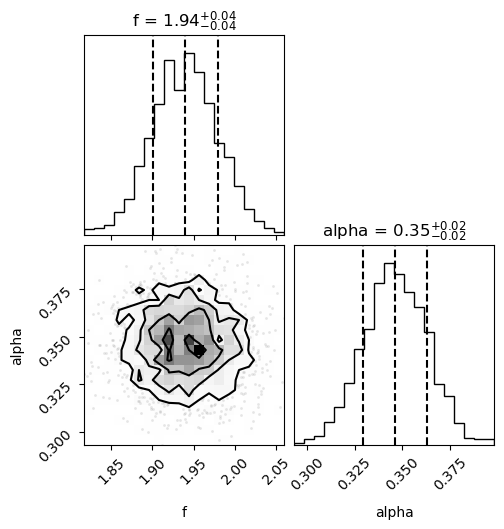

In [9]:
# Create a corner plot
samples = np.array([freq_samples, alpha_samples]).T
fig = corner.corner(samples, bins=20, labels=["f", "alpha"], show_titles=True, quantiles=[0.16, 0.5, 0.84],)

The plot above shows two 1D histograms (one for each parameter) and one 2D histogram (showing any correlations between the samples). Areas where the posterior is large (i.e. the histogram count is high) represent the most probable values of $f$ and $\alpha$ which explain the data.

The samples can also be used to provide a summary statistic. For example, if you wanted to report the mean and standard deviation interval for $f$, you could do something like this: 

In [10]:
mean_f = np.mean(freq_samples)
std_f = np.std(freq_samples)
print(f"We estimate the the mean and standard deviation of frequency to be {mean_f:0.2f}+/-{std_f:0.2f}")

We estimate the the mean and standard deviation of frequency to be 1.94+/-0.04


Typically, in GW astronomy, we use the median and a 90\% credible interval because the posterior is often non-symmetric.

In this exerise, we have learned that rejection sampling can be used to approximate the posterior distribution. However, we should note that it is highly inefficienct. It works okay here, because we tightly tuned the edges of $g(\theta)$, but if you go back and increase these to a wider range, you'll see the efficiency quickly drops off. Moreover, the efficiency of rejection sampling also suffers when we start to look at problems in more than 2 parameters.

In [11]:
# To calculate the efficiency
efficiency = len(freq_samples) / len(freq_gsamples)
print(efficiency)

0.02565


#### Parameter Estimation: Markov Chain Monte Carlo

The rejection sampling algorithm is inefficient in problems where the posterior is small compared to the prior volume. To address this, a range of stochastic sampling algorithms are available. In GW astronomy, two are preferred: Markov Chain Monte Carlo (MCMC), and Nested Sampling. We will now introduce `bilby` which is an inference package allowing access to several off the shelf samplers.

`bilby` has helper functionality to program up our likelihood and prior. We begin by using that:

In [52]:
likelihood_Ms = bilby.core.likelihood.GaussianLikelihood(time, yobs, model_Ms, sigma=0.1)

priors_Ms = dict(
    freq=bilby.core.prior.Uniform(0, 5),
    alpha=bilby.core.prior.Uniform(0, 1)
)

This creates two objects, a `likelihood` and `prior`. These can now be passed to `run_sampler` with some options to select the `bilby_mcmc` sampler and configure it in a way that is efficient for this problem.

In [13]:
result_Ms = bilby.run_sampler(
    likelihood_Ms,
    priors_Ms, 
    label="model_Ms",  # A label to help sort our results
    outdir="toy_model",  # The directory where results will be kept
    clean=True,  # Don't use cached data]
    sampler="bilby_mcmc",  # Use the bilby_mcmc sampler
    nsamples=1000,  # Draw 1000 samples
    printdt=2,  # Print an update ever 5 seconds
    L1steps=1,  # The number of internal steps to take
)

15:22 bilby INFO    : Running for label 'model_Ms', output will be saved to 'toy_model'
15:23 bilby INFO    : Analysis priors:
15:23 bilby INFO    : freq=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
15:23 bilby INFO    : alpha=Uniform(minimum=0, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
15:23 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
15:23 bilby INFO    : Analysis likelihood noise evidence: nan
15:23 bilby INFO    : Single likelihood evaluation took 8.581e-05 s
15:23 bilby INFO    : Using sampler Bilby_MCMC with kwargs {'nsamples': 1000, 'nensemble': 1, 'pt_ensemble': False, 'ntemps': 1, 'Tmax': None, 'Tmax_from_SNR': 20, 'initial_betas': None, 'adapt': True, 'adapt_t0': 100, 'adapt_nu': 10, 'pt_rejection_sample': False, 'burn_in_nact': 10, 'thin_by_nact': 1, 'fixed_discard': 0, 'autocorr_c': 5, 'L1steps': 1, 'L2steps': 3, 'printdt': 2, 'check_point_delta_t': 1800, 'min_t

5.41e+03|0:00:02|6.02e+02(10tau)|t=24|n=202|a=0.25|e=3.7e+00%|0.37ms/ev|maxl=25.98|ETF=0:00:07


15:23 bilby WARNING : Non-negligible print progress time (ppt_frac=0.05)


8.22e+03|0:00:04|2.37e+02(10tau)|t=24|n=336|a=0.34|e=4.1e+00%|0.71ms/ev|maxl=25.98|ETF=0:00:11
1.11e+04|0:00:06|2.37e+02(10tau)|t=24|n=456|a=0.39|e=4.1e+00%|0.70ms/ev|maxl=25.98|ETF=0:00:09
1.39e+04|0:00:08|2.37e+02(10tau)|t=24|n=575|a=0.42|e=4.1e+00%|0.71ms/ev|maxl=25.98|ETF=0:00:07
1.65e+04|0:00:10|2.37e+02(10tau)|t=24|n=687|a=0.44|e=4.2e+00%|0.76ms/ev|maxl=25.98|ETF=0:00:05
1.92e+04|0:00:12|2.37e+02(10tau)|t=24|n=800|a=0.45|e=4.2e+00%|0.75ms/ev|maxl=25.98|ETF=0:00:03
2.19e+04|0:00:14|2.37e+02(10tau)|t=24|n=914|a=0.46|e=4.2e+00%|0.74ms/ev|maxl=25.99|ETF=0:00:01
2.48e+04|0:00:16|2.37e+02(10tau)|t=24|n=1034|a=0.46|e=4.2e+00%|0.70ms/ev|maxl=25.99|ETF=0


15:23 bilby INFO    : Reached convergence: exiting sampling
15:23 bilby INFO    : Checkpoint start
15:23 bilby INFO    : Written checkpoint file toy_model/model_Ms_resume.pickle
15:23 bilby INFO    : Zero-temperature proposals:
15:23 bilby INFO    : AdaptiveGaussianProposal(acceptance_ratio:0.23,n:5.4e+03,scale:0.028,)
15:23 bilby INFO    : DifferentialEvolutionProposal(acceptance_ratio:0.45,n:4.6e+03,)
15:23 bilby INFO    : UniformProposal(acceptance_ratio:1,n:2.2e+02,)
15:23 bilby INFO    : KDEProposal(acceptance_ratio:0.5,n:5.4e+03,trained:1,)
15:23 bilby INFO    : FisherMatrixProposal(acceptance_ratio:0.54,n:4.6e+03,scale:1,)
15:23 bilby INFO    : GMMProposal(acceptance_ratio:0.61,n:4.6e+03,trained:1,)
15:23 bilby INFO    : Current taus={'freq': 6.9, 'alpha': 10.2}
15:23 bilby INFO    : Creating diagnostic plots
15:23 bilby INFO    : Checkpoint finished
15:23 bilby INFO    : Sampling time: 0:00:16.025988
15:23 bilby INFO    : Summary of results:
nsamples: 2452
ln_noise_evidence:   

The `run_sampler` method returns an object `result`. This contains all the interesting information that we might want to use. It also has methods we can use. For example, let's create a corner plot.

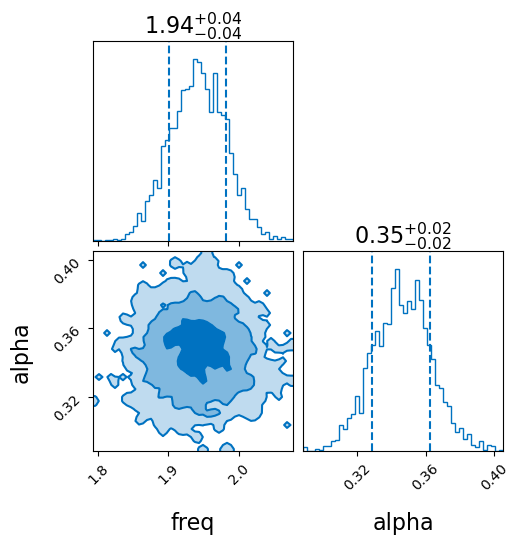

In [14]:
result_Ms.plot_corner()

We can also get to the samples, which are stored as a `pandas` data frame, as follows

In [15]:
result_Ms.posterior

,freq,alpha,log_likelihood,log_prior
0,1.944164,0.314448,23.942151,-1.609438
1,1.944164,0.314448,23.942151,-1.609438
2,1.944164,0.314448,23.942151,-1.609438
3,1.944164,0.314448,23.942151,-1.609438
4,1.944164,0.314448,23.942151,-1.609438
...,...,...,...,...
2447,1.966529,0.333049,25.435981,-1.609438
2448,1.983601,0.346396,25.410156,-1.609438
2449,1.897211,0.312243,23.130761,-1.609438
2450,2.011691,0.358920,24.016351,-1.609438


Let's compare our rejection sampling results with the `bilby_mcmc` results. To do this, we will create a histogram of the $f$ samples for both:

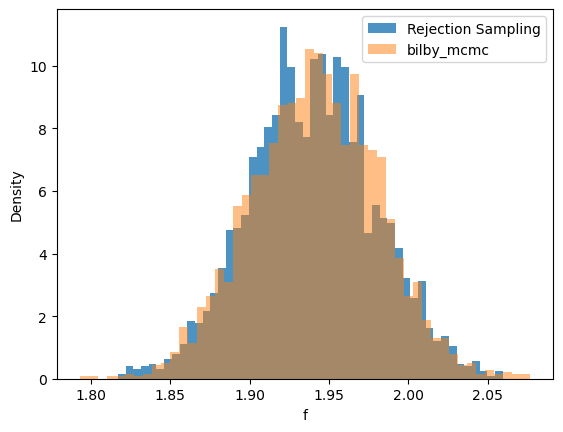

In [16]:
fig, ax = plt.subplots()
ax.hist(freq_samples, density=True, bins=50, label="Rejection Sampling", alpha=0.8)
ax.hist(result_Ms.posterior["freq"], density=True, bins=50, label="bilby_mcmc", alpha=0.5)
ax.set(xlabel="f", ylabel="Density")
plt.legend()
plt.show()

They lie on top of each other: this indicates that, within sampling errors, they are producing identical results.

## Challenge Questions

### Q1.1
To quantify agreement between distributions,  it is often useful to calculate a summary statistic and show they agree. Calculate the mean and standard deviation from the rejection sampling algorithm **and** the `bilby_mcmc` approach for both $f$ and $\alpha$. Do they agree to within the quoted standard deviation?

In [22]:
# First we extract the frequency and alpha samples from both sampling method
freq_rejection = samples[:,0]
alpha_rejection = samples[:,1]

freq_bilby = result_Ms.samples['freq']
alpha_bilby = result_Ms.samples['alpha']

In [24]:
import numpy

print("================\n FREQUENCY \n ==================")
print("Rejection sampling:")
print("\t Mean: %s" % numpy.mean(freq_rejection))
print("\t Standard deviation: %s\n" % numpy.std(freq_rejection))

print("Bilby MCMC:")
print("\t Mean: %s" % numpy.mean(freq_bilby))
print("\t Standard deviation: %s\n" % numpy.std(freq_bilby))
print("================\n")

print("================\n ALPHA \n ==================")
print("Rejection sampling:")
print("\t Mean: %s" % numpy.mean(alpha_rejection))
print("\t Standard deviation: %s\n" % numpy.std(alpha_rejection))

print("Bilby MCMC:")
print("\t Mean: %s" % numpy.mean(alpha_bilby))
print("\t Standard deviation: %s\n" % numpy.std(alpha_bilby))
print("================\n")

 FREQUENCY 
Rejection sampling:
	 Mean: 1.9395760277185514
	 Standard deviation: 0.03970627001042717

Bilby MCMC:
	 Mean: 1.9414004633767208
	 Standard deviation: 0.03999387024133914


 ALPHA 
Rejection sampling:
	 Mean: 0.3462103153958363
	 Standard deviation: 0.016568143008485445

Bilby MCMC:
	 Mean: 0.346298318858613
	 Standard deviation: 0.016965662921960285




Yes, these results are consistent with one another to within the standard deviation.

### Q1.2
Having the posterior distributions tells us about the parameters, but not if the model is a good fit to the data. For this, it is useful to use a *posterior predictive check*. Create a plot of the raw data (i.e `yobs` against `time`) Then, overlay on it the prediction of your model using the mean for $f$ and $\alpha$ estimated in Q1 (from either method).

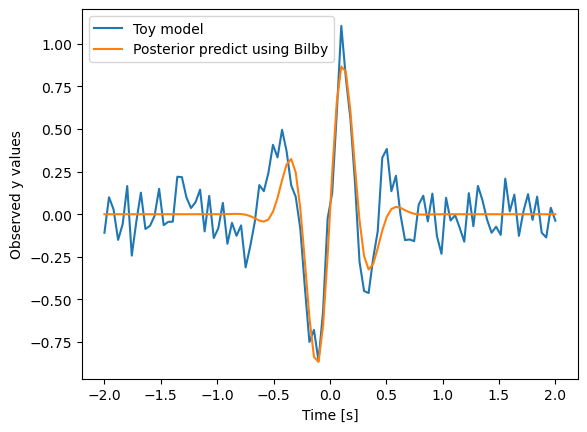

In [27]:
fig, ax = plt.subplots()
ax.plot(time, yobs, label = 'Toy model')
ax.plot(time, model_Ms(time, numpy.mean(freq_bilby), numpy.mean(alpha_bilby)), label = 'Posterior predict using Bilby')
ax.set(xlabel="Time [s]", ylabel="Observed y values")
plt.legend()
plt.show()

### Q2.1 (Optional)
It is more common to show the maximum likelihood fit and some measure of uncertainty. For the maximum likelihood, this can be obtained from the `posterior` data frame as follow:

- First identify the index of the maximum likelihood point `idx_max = np.argmax(result_Ms.posterior.log_likelihood)`
- Then return the row of the maximum `maxL = result_Ms.posterior.iloc[idx_max]`
- The values can be accessed with `maxL.freq` for example

A straightforward approach is to draw random samples from $p(\theta| d, M_s)$ and plot these. You can draw a random sample from the bilby posterior using `result.posterior.sample().iloc[0]` (this will give you a single sample with keys for `freq` and `alpha`). Draw 100 samples from the posterior and overplot them alongside your mean estimate. You will want to add `color='C3'`, `zorder=-100` and `alpha=0.1` to the `plot()` command so they don't overwhelm the rest of the plot. 

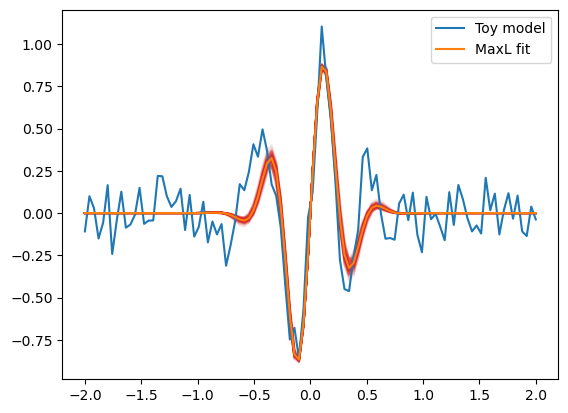

In [31]:
idx_max = np.argmax(result_Ms.posterior.log_likelihood)
maxL = result_Ms.posterior.iloc[idx_max]

fig, ax = plt.subplots()
ax.plot(time, yobs, label = 'Toy model')
ax.plot(time, model_Ms(time, maxL.freq, maxL.alpha), label = 'MaxL fit')

# Draw 100 samples and plot on top
for i in range(100):
    random_sample = result_Ms.posterior.sample().iloc[0]
    ax.plot(time, model_Ms(time, random_sample.freq, random_sample.alpha), color='C3', zorder = -100, alpha=0.1)
plt.legend()
plt.show()

### Q3.1 (Optional: hard)
Your plot from Q2 should tell you that the model isn't  fully explaining the data! You take the plot back to your tame theorist and demand an explanation. They quickly tell you that actually there is a better model where the frequency of the sinusoid is time-dependent:

$$ M_t: s(t) = e^{-(t/\alpha)^2} \sin\left(2\pi (f_0 + \dot{f} t) t\right)  $$

This new model has three parameters: $f$, $\dot{f}$ and $\alpha$. 

Your task is to program this model in a new function, then run `bilby_mcmc` on it and reproduce the figure from Q3. You will need to define new parameters $f_0$ and $\dot{f}$ in the function (probably best to call it `model_Mt` to be consistent) and add these to the prior. If you are successful, the predicted plot should nicely overlap the data. Along the way you should also create a corner plot: this can be helpful to see if you have chosen appropriate priors.

In [47]:
def time_dependent_sinusoid(time, freq, freq_dot):
    return np.sin(2 * np.pi * (freq + freq_dot * time) * time)

def model_Ms_better(time, freq, freq_dot, alpha):
    return gaussian_exponential(time, alpha) * time_dependent_sinusoid(time, freq, freq_dot)

likelihood_Ms_better = bilby.core.likelihood.GaussianLikelihood(time, yobs, model_Ms_better, sigma=0.1)

priors_Ms_better = dict(
    freq=bilby.core.prior.Uniform(0, 5),
    freq_dot = bilby.core.prior.Uniform(0,5),
    alpha=bilby.core.prior.Uniform(0, 1)
)

In [48]:
result_Ms_better = bilby.run_sampler(
    likelihood_Ms_better,
    priors_Ms_better, 
    label="model_Ms_better",  # A label to help sort our results
    outdir="toy_model_new",  # The directory where results will be kept
    clean=True,  # Don't use cached data]
    sampler="bilby_mcmc",  # Use the bilby_mcmc sampler
    nsamples=1000,  # Draw 1000 samples
    printdt=2,  # Print an update ever 5 seconds
    L1steps=1,  # The number of internal steps to take
)

15:56 bilby INFO    : Running for label 'model_Ms_better', output will be saved to 'toy_model_new'
15:56 bilby INFO    : Analysis priors:
15:56 bilby INFO    : freq=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
15:56 bilby INFO    : freq_dot=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
15:56 bilby INFO    : alpha=Uniform(minimum=0, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
15:56 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
15:56 bilby INFO    : Analysis likelihood noise evidence: nan
15:56 bilby INFO    : Single likelihood evaluation took 1.104e-04 s
15:56 bilby INFO    : Using sampler Bilby_MCMC with kwargs {'nsamples': 1000, 'nensemble': 1, 'pt_ensemble': False, 'ntemps': 1, 'Tmax': None, 'Tmax_from_SNR': 20, 'initial_betas': None, 'adapt': True, 'adapt_t0': 100, 'adapt_nu': 10, 'pt_rejection_sample': False, 'burn_in_nact': 10, 'thin_

6.26e+03|0:00:02|3.18e+03(10tau)|t=19|n=159|a=0.23|e=2.5e+00%|0.32ms/ev|maxl=76.20|ETF=0:00:05
8.86e+03|0:00:04|7.09e+02(z1)|t=19|n=424|a=0.28|e=4.8e+00%|0.77ms/ev|maxl=76.20|ETF=0:00:08
1.14e+04|0:00:06|7.09e+02(z1)|t=19|n=557|a=0.32|e=4.9e+00%|0.78ms/ev|maxl=76.20|ETF=0:00:06
1.40e+04|0:00:08|7.09e+02(z1)|t=19|n=691|a=0.33|e=4.9e+00%|0.78ms/ev|maxl=76.20|ETF=0:00:04
1.67e+04|0:00:10|7.09e+02(z1)|t=19|n=835|a=0.35|e=5.0e+00%|0.73ms/ev|maxl=76.20|ETF=0:00:02
1.94e+04|0:00:12|7.09e+02(z1)|t=19|n=975|a=0.36|e=5.0e+00%|0.74ms/ev|maxl=76.20|ETF=0:00:00
2.22e+04|0:00:14|7.09e+02(z1)|t=19|n=1118|a=0.37|e=5.0e+00%|0.73ms/ev|maxl=76.20|ETF=0


15:56 bilby INFO    : Reached convergence: exiting sampling
15:56 bilby INFO    : Checkpoint start
15:56 bilby INFO    : Written checkpoint file toy_model_new/model_Ms_better_resume.pickle
15:56 bilby INFO    : Zero-temperature proposals:
15:56 bilby INFO    : AdaptiveGaussianProposal(acceptance_ratio:0.23,n:4.1e+03,scale:0.017,)
15:56 bilby INFO    : DifferentialEvolutionProposal(acceptance_ratio:0.38,n:4.4e+03,)
15:56 bilby INFO    : UniformProposal(acceptance_ratio:1,n:2.2e+02,)
15:56 bilby INFO    : KDEProposal(acceptance_ratio:0.26,n:4.4e+03,trained:1,)
15:56 bilby INFO    : FisherMatrixProposal(acceptance_ratio:0.43,n:5e+03,scale:1,)
15:56 bilby INFO    : GMMProposal(acceptance_ratio:0.5,n:4e+03,trained:1,)
15:56 bilby INFO    : Current taus={'freq': 8.6, 'freq_dot': 10.8, 'alpha': 11.3}
15:56 bilby INFO    : Creating diagnostic plots
15:56 bilby INFO    : Checkpoint finished
15:56 bilby INFO    : Sampling time: 0:00:14.006702
15:56 bilby INFO    : Summary of results:
nsamples: 1

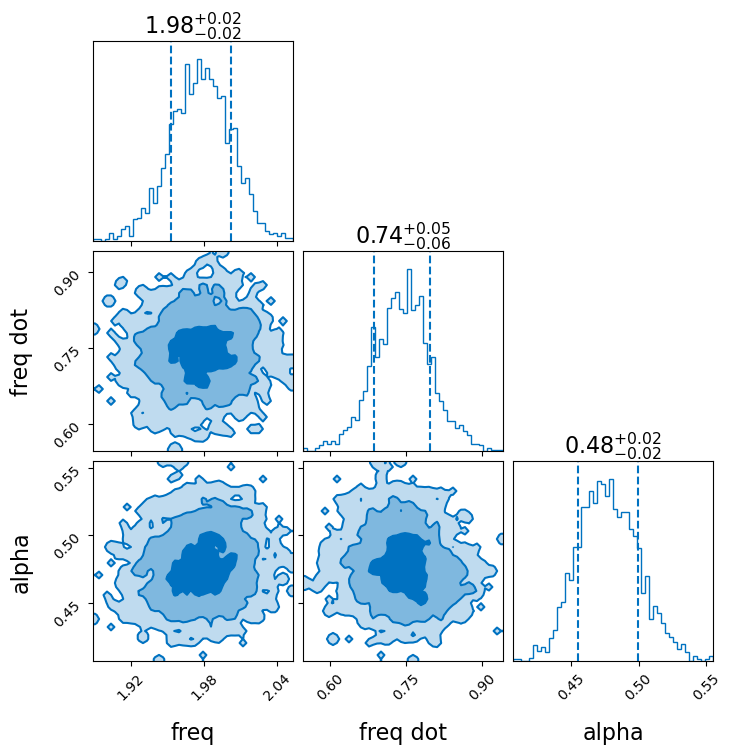

In [49]:
result_Ms_better.plot_corner()

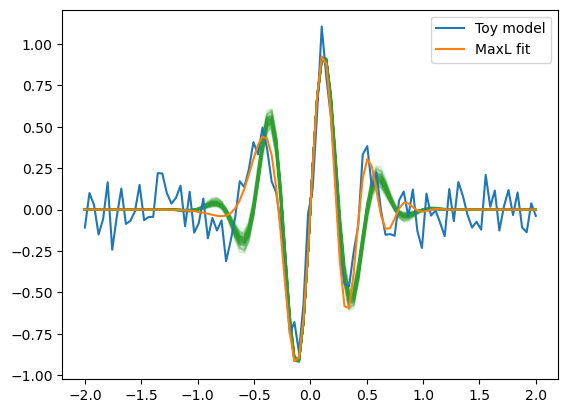

In [51]:
idx_max = np.argmax(result_Ms_better.posterior.log_likelihood)
maxL = result_Ms_better.posterior.iloc[idx_max]

fig, ax = plt.subplots()
ax.plot(time, yobs, label = 'Toy model')
ax.plot(time, model_Ms_better(time, maxL.freq, maxL.freq_dot, maxL.alpha), label = 'MaxL fit')

# Draw 100 samples and plot on top
for i in range(100):
    random_sample = result_Ms_better.posterior.sample().iloc[0]
    ax.plot(time, model_Ms(time, random_sample.freq, random_sample.alpha), color='C2', zorder = -100, alpha=0.1)
plt.legend()
plt.show()

### Q3.2 (Optional)
We can tell already that the $M_t$ model is far better than $M_s$: the posterior predictive fit better explains the data. One can also look at the posterior of $\dot{f}$ from $M_t$: Since $M_s$ is a subset of $M_t$ (i.e. they are equivalent when $\dot{f}=0$) the fact that the the posterior on $\dot{f}$ peaks away from zero tells you that $M_t$ is better than $M_s$.

However, it is fun to also show how we can quantify this using the posterior odds (defined in the first section!). For this, we need to calculate the evidence $\mathcal{Z}(d | M_s)$ and $\mathcal{Z}(d | M_t)$. They can be estimated by stochastic sampling. However, `bilby_mcmc` is not the right tool (in can in principle, but the alternative is superior for evidence calculation). Instead, we should use the **nested sampling** package `dynesty`

- Rerun your analysis of both models, but use `sampler="dynesty"` in `run_sampler`. You will also need to add configuration arguments: `nlive=500, sampler="rwalk"`)
- Calculate the Bayes factor using `np.exp(result_Mt.log_evidence - result_Mt.log_evidence)`

In [54]:
result_Ms_dynesty = bilby.run_sampler(
    likelihood_Ms,
    priors_Ms, 
    label="model_Ms_dynesty",  # A label to help sort our results
    outdir="toy_model_dynesty",  # The directory where results will be kept
    clean=True,  # Don't use cached data]
    sampler="dynesty",  # Use the bilby_mcmc sampler
    nlive = 500,
    sample = 'rwalk',
    nsamples=1000,  # Draw 1000 samples
    printdt=2,  # Print an update ever 5 seconds
    L1steps=1,  # The number of internal steps to take
)

result_Ms_better_dynesty = bilby.run_sampler(
    likelihood_Ms_better,
    priors_Ms_better, 
    label="model_Ms_better_dynesty",  # A label to help sort our results
    outdir="toy_model_new_dynesty",  # The directory where results will be kept
    clean=True,  # Don't use cached data]
    sampler="dynesty",  # Use the bilby_mcmc sampler
    nlive = 500,
    sample = 'rwalk',
    nsamples=1000,  # Draw 1000 samples
    printdt=2,  # Print an update ever 5 seconds
    L1steps=1,  # The number of internal steps to take
)

16:02 bilby INFO    : Running for label 'model_Ms_dynesty', output will be saved to 'toy_model_dynesty'
16:03 bilby INFO    : Analysis priors:
16:03 bilby INFO    : freq=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
16:03 bilby INFO    : alpha=Uniform(minimum=0, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
16:03 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
16:03 bilby INFO    : Analysis likelihood noise evidence: nan
16:03 bilby INFO    : Single likelihood evaluation took 1.020e-04 s
16:03 bilby WARNING : Supplied argument 'nsamples' not an argument of 'Dynesty', removing.
16:03 bilby WARNING : Supplied argument 'printdt' not an argument of 'Dynesty', removing.
16:03 bilby WARNING : Supplied argument 'L1steps' not an argument of 'Dynesty', removing.
16:03 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 500, 'bound': 'live', 'sample': 'rwalk', 'periodic': None, 'refle

1it [00:00, ?it/s]

16:03 bilby INFO    : Written checkpoint file toy_model_dynesty/model_Ms_dynesty_resume.pickle
16:03 bilby INFO    : Rejection sampling nested samples to obtain 1354 posterior samples
16:03 bilby INFO    : Sampling time: 0:00:14.764327
16:03 bilby INFO    : Summary of results:
nsamples: 1354
ln_noise_evidence:    nan
ln_evidence: 18.724 +/-  0.140
ln_bayes_factor:    nan +/-  0.140

16:03 bilby INFO    : Running for label 'model_Ms_better_dynesty', output will be saved to 'toy_model_new_dynesty'
16:03 bilby WARNING : Parameter logp has no default prior and is set to -3.2188758248682006, this will not be sampled and may cause an error.
16:03 bilby WARNING : Parameter logl has no default prior and is set to 73.853213272951, this will not be sampled and may cause an error.


16:03 bilby INFO    : Analysis priors:
16:03 bilby INFO    : freq=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
16:03 bilby INFO    : freq_dot=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
16:03 bilby INFO    : alpha=Uniform(minimum=0, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
16:03 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
16:03 bilby INFO    : Analysis likelihood noise evidence: nan
16:03 bilby INFO    : Single likelihood evaluation took 1.100e-04 s
16:03 bilby WARNING : Supplied argument 'nsamples' not an argument of 'Dynesty', removing.
16:03 bilby WARNING : Supplied argument 'printdt' not an argument of 'Dynesty', removing.
16:03 bilby WARNING : Supplied argument 'L1steps' not an argument of 'Dynesty', removing.
16:03 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 500, 'bound': 'live', 'sample': 'rwalk', 'periodic': 

1it [00:00, ?it/s]

16:04 bilby INFO    : Written checkpoint file toy_model_new_dynesty/model_Ms_better_dynesty_resume.pickle
16:04 bilby INFO    : Rejection sampling nested samples to obtain 1621 posterior samples
16:04 bilby INFO    : Sampling time: 0:00:25.339984


16:04 bilby INFO    : Summary of results:
nsamples: 1621
ln_noise_evidence:    nan
ln_evidence: 65.390 +/-  0.170
ln_bayes_factor:    nan +/-  0.170



In [59]:
print("The log Bayes factor is %s" % (result_Ms_better_dynesty.log_evidence - result_Ms_dynesty.log_evidence))

The log Bayes factor is 46.66594826826938


### Q4.1 (Optional: easy)

Throughout all our analyses, we assumed that $\sigma=0.1$. But, what would we do if we didn't know this a priori? One option is to estimate it, you can do this by simply taking the standard deviation of data away from where the transient signal is. First, try to cut out the first 1s of data and use this to estimate $\sigma$, is it close to the true value $0.1$? How about taking the last second of data?

In [63]:
print("For the first second of data...")
idx = np.where(time <= time[0]+1)
std = np.std(yobs[idx])
print("Sigma is %s.\n" % std)

print("For the last second of data...")
idx = np.where(time >= time[-1]-1)
std = np.std(yobs[idx])
print("Sigma is %s." % std)

For the first second of data...
Sigma is 0.12083232379507279.

For the last second of data...
Sigma is 0.10246210029527959.


Both are close to 0.1, but there is some scatter.

### Q4.2 (Optional: harder)

If we did not know $\sigma$ a priori, and we didn't trust our estimate, we could simply infer it from the data! You can do this by removing the `sigma=0.1` in the `GaussianLikelihood` and setting a prior on sigma. Try this using your $M_t$ model.

In [69]:
def time_dependent_sinusoid(time, freq, freq_dot):
    return np.sin(2 * np.pi * (freq + freq_dot * time) * time)

def model_Ms_better(time, freq, freq_dot, alpha):
    return gaussian_exponential(time, alpha) * time_dependent_sinusoid(time, freq, freq_dot)

likelihood_Ms_better = bilby.core.likelihood.GaussianLikelihood(time, yobs, model_Ms_better, sigma = std)

priors_Ms_better = dict(
    freq=bilby.core.prior.Uniform(0, 5),
    freq_dot = bilby.core.prior.Uniform(0,5),
    alpha=bilby.core.prior.Uniform(0, 1)
)

In [70]:
result_Ms_better = bilby.run_sampler(
    likelihood_Ms_better,
    priors_Ms_better, 
    label="model_Ms_better_no_sigma",  # A label to help sort our results
    outdir="toy_model_new_no_sigma",  # The directory where results will be kept
    clean=True,  # Don't use cached data]
    sampler="dynesty",  # Use the bilby_mcmc sampler
    nlive = 500,
    sample = 'rwalk',
    nsamples=1000,  # Draw 1000 samples
    printdt=2,  # Print an update ever 5 seconds
    L1steps=1,  # The number of internal steps to take
)

16:13 bilby INFO    : Running for label 'model_Ms_better_no_sigma', output will be saved to 'toy_model_new_no_sigma'
16:13 bilby INFO    : Analysis priors:
16:13 bilby INFO    : freq=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
16:13 bilby INFO    : freq_dot=Uniform(minimum=0, maximum=5, name=None, latex_label=None, unit=None, boundary=None)
16:13 bilby INFO    : alpha=Uniform(minimum=0, maximum=1, name=None, latex_label=None, unit=None, boundary=None)
16:13 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
16:13 bilby INFO    : Analysis likelihood noise evidence: nan
16:13 bilby INFO    : Single likelihood evaluation took 1.036e-04 s
16:13 bilby WARNING : Supplied argument 'nsamples' not an argument of 'Dynesty', removing.
16:13 bilby WARNING : Supplied argument 'printdt' not an argument of 'Dynesty', removing.
16:13 bilby WARNING : Supplied argument 'L1steps' not an argument of 'Dynesty', removing.
16

1it [00:00, ?it/s]

16:13 bilby INFO    : Written checkpoint file toy_model_new_no_sigma/model_Ms_better_no_sigma_resume.pickle
16:13 bilby INFO    : Rejection sampling nested samples to obtain 1639 posterior samples
16:13 bilby INFO    : Sampling time: 0:00:24.491578


16:13 bilby INFO    : Summary of results:
nsamples: 1639
ln_noise_evidence:    nan
ln_evidence: 65.839 +/-  0.170
ln_bayes_factor:    nan +/-  0.170



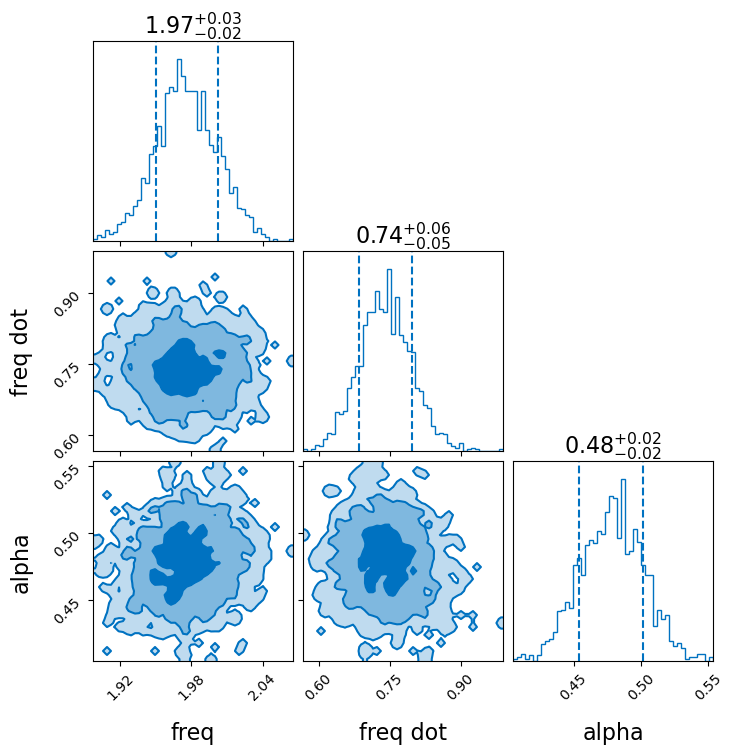

In [72]:
result_Ms_better.plot_corner()